In [2]:
%load_ext autoreload
%autoreload 2
from nbutils import chdir_to_root
chdir_to_root()

In [3]:
from cudams.utils import \
    argbatch, mkdir, get_ref_spectra_from_df
import math
from pathlib import Path
import pandas as pd
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import cupy as cp

cp.cuda.is_available()

True

In [4]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 2048

# MAX NUMBER OF PEAKS during filtering. Due to nature of matrices, having large number of 
# peaks will increase memory requirements. After 1024, this has diminishing benefits, as 
# smaller and smaller (likely noisy) peaks are taken into consideration when running similarity.
MAX_PEAKS = 1024

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float32'

# Data path
reference_csv_file = Path("data/input/example_dataset_tornike.csv")
query_csv_file = Path("data/input/example_dataset_tornike.csv")

In [5]:
from cudams.utils import get_spectra_batches
len_spectra = 1024
references, queries, batches_inputs = get_spectra_batches(
    batch_size=BATCH_SIZE,
    max_peaks=MAX_PEAKS,
    max_pairs=16 * (BATCH_SIZE ** 2), # 16 batches, give or take...
    padding=len_spectra,
)
TOTAL_BATCHES = len(batches_inputs)
batch_outputs = np.empty(shape=(TOTAL_BATCHES,4),dtype=object)

100%|██████████| 16384/16384 [00:06<00:00, 2475.21it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
  0%|          | 0/16 [00:07<?, ?it/s]


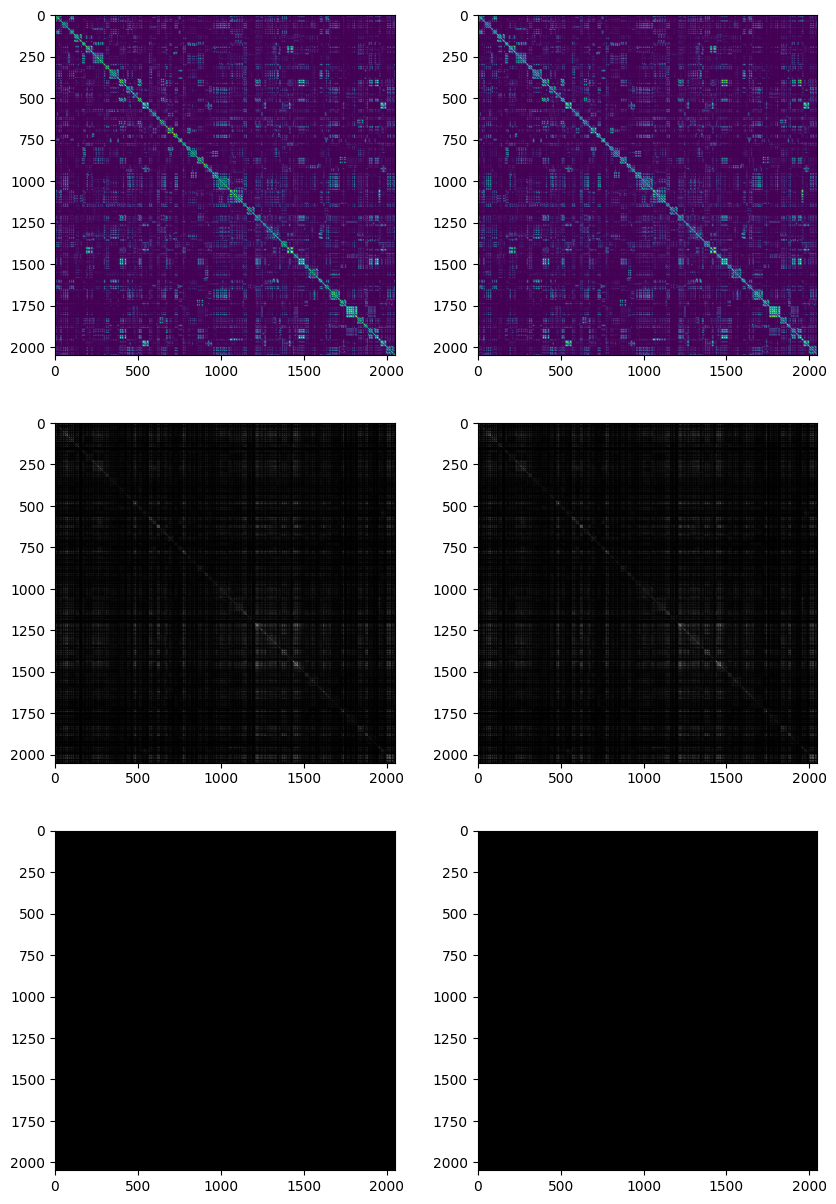

In [34]:
from cudams.similarity.kernels import compile_cuda_cosine_greedy_kernel

n_kernel = compile_cuda_cosine_greedy_kernel(
    tolerance=tolerance,
    shift=shift,
    mz_power=mz_power,
    int_power=int_power,
    match_limit=MATCH_LIMIT,
    batch_size=BATCH_SIZE
)

kernel = cp.RawKernel(
    f"""
    #define R {BATCH_SIZE}
    #define Q {BATCH_SIZE}
    #define MATCH_LIMIT {MATCH_LIMIT}
    #define tolerance {tolerance}
    #define shift {shift}
    #define len_spectra {len_spectra}
    #define int_power {int_power}
    #define mz_power {mz_power}
    """ r"""
    __device__ inline int ix2(const int i, const int j) { return i + R * j; }
    
    extern "C" __global__
    void kernel(
        const float* __restrict__ rmz,
        const float* __restrict__ rint,
        
        const float* __restrict__ qmz,
        const float* __restrict__ qint,
        
        const int* __restrict__ rlen,
        const int* __restrict__ qlen,
        
        float* __restrict__ scores,
        int* __restrict__ used_matches,
        char* __restrict__ overflow
    ) {
        // We imagine x axis as references and y axis as queries
        const int i = blockIdx.y * blockDim.y + threadIdx.y;
        const int j = blockIdx.x * blockDim.x + threadIdx.x;
        
        const int ix_out = i * R + j;
        
        int thread_i = threadIdx.x;
        int thread_j = threadIdx.y;
        int block_size_x = blockDim.x;
        int block_size_y = blockDim.y;
        
        if (i < R && j < Q) {
            
            overflow[ix_out] = 0;
            scores[ix_out] = 0;
            used_matches[ix_out] = 0;
            // return;
            
            // rmz = rspec[0] rmz shape is [R, C]
            // rint = rspec[1] 
            // qmz = qspec[0]  qmz shape is [Q, C]
            // qint = qspec[1]
            
            // rlen = lens[0]
            // qlen = lens[1]

            const auto rleni = rlen[i]; 
            const auto qlenj = qlen[j];
            
            if (rleni == 0 || qlenj == 0) {
                return;
            }
            
            const auto spec1_mz = i; // [C]
            const auto spec1_int = i; // [C]
            
            const auto spec2_mz = j; // [C] have to take an index, not value, because 
            const auto spec2_int = j; // [C] cuda doesn't allow 2d arrays
            
            int lowest_idx = 0;
            int num_match = 0;
            
            int matches[2][MATCH_LIMIT];
            for (int peak1_idx = 0; peak1_idx < rleni; peak1_idx++) {
                
                const auto mz = rmz[spec1_mz * len_spectra + peak1_idx];
                const auto low_bound = mz - tolerance;
                const auto high_bound = mz + tolerance;
                
                for (int peak2_idx = lowest_idx; peak2_idx < qlenj; peak2_idx++) {
                    const auto mz2 = qmz[spec2_mz * len_spectra + peak2_idx] + shift;
                    if (mz2 > high_bound) {
                        break;
                    } 
                    if (mz2 < low_bound) {
                        lowest_idx = peak2_idx + 1;
                    } else {
                        if (num_match < MATCH_LIMIT) {
                            matches[0][num_match] = peak1_idx;
                            matches[1][num_match] = peak2_idx;
                            num_match++;
                        } else {
                            overflow[ix_out] = 1;
                            break;
                        }
                    }
                }
            }
            
            // used_matches[ix_out] = num_match;
            // return;
            
            if (num_match == 0) {
                return;
            }
            
            float score_norm = 1.0;
            double score_norm_spec1 = 0.0;
            double score_norm_spec2 = 0.0;
            
            for (int peak1_idx = 0; peak1_idx < rleni; ++peak1_idx) {
                score_norm_spec1 += pow(
                    pow(rmz[spec1_mz * len_spectra + peak1_idx], mz_power) * 
                    pow(rint[spec1_int * len_spectra + peak1_idx], int_power), 
                    2
                );
            }
            
            for (int peak2_idx = 0; peak2_idx < qlenj; ++peak2_idx) {
                score_norm_spec2 += pow(
                    pow(qmz[spec2_mz * len_spectra + peak2_idx], mz_power) * 
                    pow(qint[spec2_int * len_spectra + peak2_idx], int_power), 
                    2
                );
            }
            
            score_norm = sqrt(score_norm_spec1 * score_norm_spec2);
            
            // scores[ix_out] = score_norm; // for debugging
            // return;
            
            float score = 0;
            int used_match = 0;
            for (int z = 0; z < num_match; z++) {
                float max_prod = -1;
                int max_peak1_idx;
                int max_peak2_idx;
                for (int sj = 0; sj < num_match; sj++) {
                    if (matches[0][sj] != -1) {
                        const auto peak1_idx = matches[0][sj];
                        const auto peak2_idx = matches[1][sj];
                        
                        const auto power_prod_spec1 = (
                            pow(rmz[spec1_mz * len_spectra + peak1_idx], mz_power) * 
                            pow(rint[spec1_int * len_spectra + peak1_idx], int_power)
                        );
                        
                        const auto power_prod_spec2 = (
                            pow(qmz[spec2_mz * len_spectra + peak2_idx], mz_power) * 
                            pow(qint[spec2_int * len_spectra + peak2_idx], int_power)
                        );
                        
                        const auto prod = power_prod_spec1 * power_prod_spec2;
                        
                        if (prod >= max_prod) {
                            max_prod = prod;
                            max_peak1_idx = peak1_idx;
                            max_peak2_idx = peak2_idx;
                        }
                    }
                }
                
                if (max_prod != -1) {
                    for (int sj = 0; sj < num_match; sj++) {
                        if (
                            matches[0][sj] == max_peak1_idx
                            || matches[1][sj] == max_peak2_idx
                        ) {
                            matches[0][sj] = -1;
                            matches[1][sj] = -1;
                        }
                    }
                    score += max_prod;
                    used_match++;
                } else {
                    break;
                }
            }
            
            score = score / score_norm;
            
            scores[ix_out] = score;
            used_matches[ix_out] = used_match;
        }
    }
    """,
    'kernel',
    backend='nvcc',
    options=(
        "-std=c++11",
        "-use_fast_math",
        "-lineinfo",
        "-Xptxas",
        "-v -warn-spills -warn-lmem-usage",
    ),
)

R, Q = BATCH_SIZE, BATCH_SIZE
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(R / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(Q / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

for batch_i in tqdm(range(TOTAL_BATCHES)):
        # We get our batch and lengths (lengths are different for different spectra)
    (rspec, rlen, rstart, rend), (qspec, qlen, qstart, qend) = batches_inputs[
        batch_i
    ]
    
    lens = np.zeros((2, BATCH_SIZE), "int32")
    lens[0, :len(rlen)] = rlen
    lens[1, :len(qlen)] = qlen
    
    
    # We order empty space for results on GPU RAM
    scores = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="float32"
    )
    used_matches = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="int32"
    )
    overflow = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE), dtype="uint8"
    )

    rmz = cp.asarray(rspec[0])
    rint = cp.asarray(rspec[1])
    
    qmz = cp.asarray(qspec[0])
    qint = cp.asarray(qspec[1])
    
    rlen = cp.asarray(lens[0])
    qlen = cp.asarray(lens[1])
    
    # rnorm = ((rmz ** mz_power) * (rint ** int_power)).sum()
    
    kernel(
        BLOCKS_PER_GRID, 
        THREADS_PER_BLOCK,
        (
            rmz,
            rint,
            
            qmz,
            qint,
            
            rlen,
            qlen,
            
            scores,
            used_matches,
            overflow,
        )
    )
    nout = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE, 2), dtype="float32"
    )
    noverflow = cp.zeros(
        (BATCH_SIZE, BATCH_SIZE, 1), dtype="uint8"
    )
    n_kernel(
        rspec,
        qspec,
        lens,
        nout,
        noverflow,
    )
    break


plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
plt.imshow(scores.get())
plt.subplot(3,2,2)
plt.imshow(nout[...,0].get())

plt.subplot(3,2,3)
plt.imshow(used_matches.get(), cmap='gray')
plt.subplot(3,2,4)
plt.imshow(nout[...,1].get(), cmap='gray')

plt.subplot(3,2,5)
plt.imshow(overflow.get(), cmap='gray')
plt.subplot(3,2,6)
plt.imshow(noverflow[...,0].get(), cmap='gray')

In [40]:
np.allclose(used_matches.get(), nout[...,1].get())

False

In [36]:
a,b = scores.get(), nout[...,0].get()
np.allclose(a,b, atol=1e-4)

False

In [37]:
a

array([[1.        , 0.99049497, 0.9773932 , ..., 0.        , 0.        ,
        0.        ],
       [0.99049497, 1.        , 0.99278593, ..., 0.        , 0.        ,
        0.        ],
       [0.9773932 , 0.99278593, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0000001 , 0.9453451 ,
        0.80221635],
       [0.        , 0.        , 0.        , ..., 0.9453451 , 0.9999998 ,
        0.94518346],
       [0.        , 0.        , 0.        , ..., 0.80221635, 0.94518346,
        1.0000001 ]], dtype=float32)

In [38]:
b

array([[0.99999994, 0.99049497, 0.97739315, ..., 0.        , 0.        ,
        0.        ],
       [0.99049497, 1.        , 0.9927858 , ..., 0.        , 0.        ,
        0.        ],
       [0.97739315, 0.9927858 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0000001 , 0.94534516,
        0.80221635],
       [0.        , 0.        , 0.        , ..., 0.94534516, 0.9999998 ,
        0.94518346],
       [0.        , 0.        , 0.        , ..., 0.80221635, 0.94518346,
        1.0000001 ]], dtype=float32)

In [24]:
nout[...,0]

array([[0.99999994, 0.99049497, 0.97739315, ..., 0.        , 0.        ,
        0.        ],
       [0.99049497, 1.        , 0.9927858 , ..., 0.        , 0.        ,
        0.        ],
       [0.97739315, 0.9927858 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.0000001 , 0.94534516,
        0.80221635],
       [0.        , 0.        , 0.        , ..., 0.94534516, 0.9999998 ,
        0.94518346],
       [0.        , 0.        , 0.        , ..., 0.80221635, 0.94518346,
        1.0000001 ]], dtype=float32)

In [15]:
rmz.shape, qmz.shape

((2048, 211), (2048, 211))

In [44]:
lens.shape

(2, 2048)

In [37]:
rspec.shape

(2, 2048, 211)

In [38]:
lens

array([[14, 15, 14, ..., 51, 50, 48],
       [14, 15, 14, ..., 51, 50, 48]], dtype=int32)

In [61]:
BLOCKS_PER_GRID

(64, 64)

In [60]:
rspec.shape, qspec.shape

((2, 2048, 211), (2, 2048, 211))

In [44]:
rspec.shape

(2, 2048, 211)

In [43]:
out[0,0]

array([0., 1.], dtype=float32)

In [8]:
from cudams.kernel import compile

kernel = compile(
    tolerance=tolerance,
    shift=shift,
    mz_power=mz_power,
    int_power=int_power,
    match_limit=MATCH_LIMIT,
    batch_size=BATCH_SIZE
)

In [9]:

def end_of_stream_callback(
        stream, 
        status, 
        rstart,
        rend,
        qstart,
        qend):
    pass
    # We order a data return
    
    # out = out_cu.copy_to_host(stream=stream)
    # overflow = overflow_cu.copy_to_host(stream=stream)
    # lens = lens_cu.copy_to_host(stream=stream)
    
    # mask = out[:len(rlen),:len(qlen),0] >= threshold
    # # r, c = np.nonzero(mask)
    # out = out[r,c]
    # overflow = overflow[r,c]
    # r += rstart
    # c += qstart
    # batch_outputs[batch_i] = r, c, out, overflow

In [16]:
# We loop over all batchs in sequence
out = np.empty(
    shape=(BATCH_SIZE, BATCH_SIZE, 2),
    dtype="float32",
)

overflow = np.empty(
    shape=(BATCH_SIZE, BATCH_SIZE, 1),
    dtype="uint8",
)
for batch_i in tqdm(range(30)):
    stream = cuda.stream()
    # stream = cuda.default_stream()
    # Each batch has own CUDA stream so that the GPU is as busy as possible

    # We get our batch and lengths (lengths are different for different spectra)
    (rspec, rlen, rstart, rend), (qspec, qlen, qstart, qend) = batches_rq[
        batch_i
    ]
    lens = np.zeros((2, BATCH_SIZE), "int32")
    lens[0, : len(rlen)] = rlen
    lens[1, : len(qlen)] = qlen

    # We make sure main resources remain on CPU RAM
    with cuda.pinned(
        rspec,
        qspec,
        lens,
        out,
        overflow,
    ):
        # We order empty space for results on GPU RAM
        out_cu = cuda.device_array(
            (BATCH_SIZE, BATCH_SIZE, 2), dtype="float32",
            stream=stream
        )
        overflow_cu = cuda.device_array(
            (BATCH_SIZE, BATCH_SIZE, 1), dtype="uint8",
            stream=stream
        )

        # We order the stream to copy input data to GPU RAM
        rspec_cu = cuda.to_device(rspec, stream=stream)
        qspec_cu = cuda.to_device(qspec, stream=stream)
        lens_cu = cuda.to_device(lens, stream=stream)

        # We order the stream to execute kernel (this is scheduled, it will execute, but we can't force it)
        kernel(
            rspec_cu, qspec_cu, lens_cu, out_cu, overflow_cu,
            stream=stream
        )
        # result_output[rstart:rend, qstart:qend] = out
        # result_overflow[rstart:rend, qstart:qend] = overflow
        def cb(stream, status, rstart, rend, qstart, qend):
            print(stream, status, rstart, rend, qstart, qend)
            
        stream.add_callback(
            callback=cb,
            arg=[
                rstart,
                rend,
                qstart,
                qend,
            ],
        )
# We wait for all streams to finish their work everywhere
cuda.synchronize()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


In [40]:
from cudams.processor import CudaCosineGreedy
from tqdm import tqdm

rlims = argbatch(refs, BATCH_SIZE)
qlims = argbatch(ques, BATCH_SIZE)

R = len(references)
Q = len(queries)

batches_rq = list(product(rlims, qlims))

cosine = CudaCosineGreedy(
    tolerance=tolerance,
    mz_power=0,
    intensity_power=1, 
    shift=0,
    batch_size=BATCH_SIZE,
    match_limit=MATCH_LIMIT,
)
cosine.compile()
t = perf_counter()
ri, qi, out, overflows = cosine.matrix(
    references=references, 
    queries=queries, 
    array_type="sparse",
    sparse_threshold=.75,
)
t = perf_counter() - t
sum_nbytes = sum(o.nbytes for o in [ri, qi, out, overflows])
print(f"Output size {sum_nbytes / 1e9:.2f}GB")
print(f"Num of output {len(ri)}")
print(f"Pairs processed {len(references) * len(queries):.1e}")
n_pairs = len(references) * len(queries)
perh = (n_pairs / t) * 3600

print(f"pairs per hr {perh:.1e}")
print(f"Full run (100kx1.5mln) est: {100_000 * 1_500_000 / perh:.3f}hrs")
print(f"Full run (100kx1.5mln) est GBs: {(sum_nbytes/n_pairs)*(100_000*1_500_000)*1e-9:.2f}GB")

Batch all references: 46it [00:01, 27.33it/s]
Batch all queries: 46it [00:01, 27.86it/s]
  0%|          | 0/2116 [00:00<?, ?it/s]/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/cudadrv/driver.py:2290: UserWarning: Exception in stream callback: CudaCosineGreedy._matrix_with_sparse_output.<locals>.end_of_stream_callback() missing 3 required positional arguments: 'rend', 'qstart', and 'qend'
  warnings.warn(f"Exception in stream callback: {e}")
  3%|▎         | 61/2116 [00:21<14:36,  2.34it/s] Exception ignored in: <finalize object at 0x7f64e452c640; dead>
Traceback (most recent call last):
  File "/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/weakref.py", line 591, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/cudadrv/driver.py", line 1660, in core
    driver.cuMemHostUnregister(ptr)
  File "/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages